In [1]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from nltk.corpus import stopwords
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import words
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
cv = CountVectorizer(binary=True)
stop = stopwords.words('english')

Using TensorFlow backend.


In [25]:
import torch

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv("sa-emotions/train_data.csv")

In [4]:
df_train.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [5]:
def cleaner(tes):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_U_NAME = re.compile("@[\S]+")
    REPLACE_DIGITS = re.compile("\d")
    REPLACE_W_SPACE = re.compile("_")
    tes["content"] = tes["content"].str.replace(REPLACE_NO_SPACE, '')
    tes["content"] = tes["content"].str.replace(REPLACE_U_NAME,'')
    tes["content"] = tes["content"].str.replace(REPLACE_DIGITS,'')
    tes["content"] = tes["content"].str.replace(REPLACE_W_SPACE,'')
    tes["content"] = tes["content"].str.lower()
    return tes
    

In [6]:
df_train = cleaner(df_train)

In [7]:
df_train.head()

,sentiment,content
0,empty,i know i was listenin to bad habit earlier a...
1,sadness,layin n bed with a headache ughhhhwaitin on y...
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,wants to hang out with friends soon
4,neutral,we want to trade with someone who has houston...


## Binary Classification

In [8]:
df_bin = df_train.loc[(df_train['sentiment'] == 'sadness') | (df_train['sentiment'] == 'happiness')]

In [9]:
df_bin.head()

,sentiment,content
1,sadness,layin n bed with a headache ughhhhwaitin on y...
2,sadness,funeral ceremonygloomy friday
6,sadness,i should be sleep but im not thinking about an...
8,sadness,charlene my love i miss you
9,sadness,im sorry at least its friday


In [10]:
df_bin.sentiment.value_counts()

sadness      4828
happiness    2986
Name: sentiment, dtype: int64

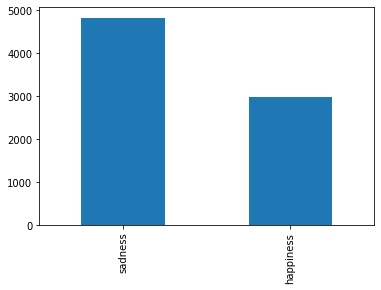

In [11]:
df_bin['sentiment'].value_counts().plot('bar')
plt.show()

 From the above plot we can note that the classes are imbalanced, We'll be using SMOTE to rectify this imbalance.

In [12]:
def model_report(train_data,test_data,train_labels,test_labels):
    lsvc = LinearSVC(random_state=0, tol=1e-5)
    rf = RandomForestClassifier(n_estimators=100)
    et = ExtraTreesClassifier(n_estimators=100, random_state=0)
    xgb = XGBClassifier()
    adb = AdaBoostClassifier(n_estimators=100, random_state=0)
    models = {'LinearSVC':lsvc,'RandomForest':rf,'ExtraTrees':et,'XGBoost':xgb,'AdaBoost':adb}
    for model_name, model in models.items():
        model.fit(train_data, train_labels)
        print("Accuracy for {} is {}".format(model_name,accuracy_score(test_labels, model.predict(test_data))))
        predicted = model.predict(test_data)
        print(classification_report(test_labels,predicted))

### CountVectorizer

In [13]:
cv.fit(df_bin["content"])
count_vec = cv.transform(df_bin["content"])
# X_test_vec = cv.transform(X_test)

In [14]:
df_bin["sentiment"].value_counts()

sadness      4828
happiness    2986
Name: sentiment, dtype: int64

In [15]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(count_vec, df_bin['sentiment'])

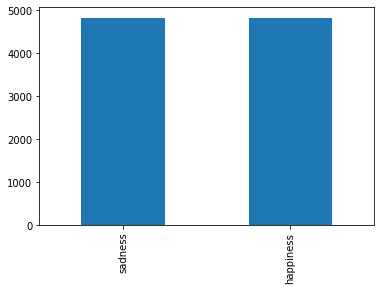

In [70]:
y_SMOTE.value_counts().plot('bar')
plt.show()

In [17]:
def int_enc(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    return(integer_encoded)

In [18]:
cv_labels = int_enc(np.array(df_bin['sentiment']))
y_labels = int_enc(np.array(y_SMOTE))

In [19]:
cv_X_train, cv_X_test, cv_y_train, cv_y_test = train_test_split(count_vec, cv_labels, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_labels, test_size=0.33, random_state=42)


#### Logistic Regression

In [20]:
def param_search(train_features,y_train):
    parameters = {'C': np.linspace(1, 0.0001, 100, 20)}
    grid_search = GridSearchCV(LogisticRegression(), parameters)
    grid_search.fit(train_features, y_train)

    print('best parameters: ', grid_search.best_params_)
    print('best scrores: ', grid_search.best_score_)

In [21]:
# param_search(cv_X_train, cv_y_train)

best parameters:  {'C': 0.6162000000000001}
best scrores:  0.7902578796561605


In [22]:
#non-SMOTE
c = 0.1920 #value from grid search
lr = LogisticRegression(C=c)
lr.fit(cv_X_train, cv_y_train)
print ("Accuracy for C=%s: %s" 
   % (c, accuracy_score(cv_y_test, lr.predict(cv_X_test))))

Accuracy for C=0.192: 0.7758821248545948


In [23]:
predicted = lr.predict(cv_X_test)
print(classification_report(cv_y_test,predicted))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66       954
           1       0.79      0.89      0.83      1625

    accuracy                           0.78      2579
   macro avg       0.77      0.74      0.75      2579
weighted avg       0.77      0.78      0.77      2579



### LogisticRegression with SMOTE

In [24]:
# param_search(X_train, y_train)

best parameters:  {'C': 0.8081}
best scrores:  0.8097076040168736


In [25]:
c = 0.9798 #value from gridsearch
lr = LogisticRegression(C=c)
lr.fit(X_train, y_train)
print ("Accuracy for C=%s: %s" 
   % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.9798: 0.8107938500156887


In [26]:
predicted = lr.predict(X_test)
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1541
           1       0.84      0.78      0.81      1646

    accuracy                           0.81      3187
   macro avg       0.81      0.81      0.81      3187
weighted avg       0.81      0.81      0.81      3187



### Before SMOTE

In [27]:
model_report(cv_X_train, cv_X_test, cv_y_train, cv_y_test)

Accuracy for LinearSVC is 0.7638619620007755
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       954
           1       0.81      0.82      0.81      1625

    accuracy                           0.76      2579
   macro avg       0.75      0.74      0.75      2579
weighted avg       0.76      0.76      0.76      2579

Accuracy for RandomForest is 0.7564947654129508
              precision    recall  f1-score   support

           0       0.77      0.49      0.60       954
           1       0.75      0.92      0.83      1625

    accuracy                           0.76      2579
   macro avg       0.76      0.70      0.71      2579
weighted avg       0.76      0.76      0.74      2579

Accuracy for ExtraTrees is 0.7681271810779372
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       954
           1       0.77      0.90      0.83      1625

    accuracy                           0.77

### After SMOTE

In [28]:
model_report(X_train, X_test, y_train, y_test)

Accuracy for LinearSVC is 0.7973015374960778
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1541
           1       0.83      0.76      0.79      1646

    accuracy                           0.80      3187
   macro avg       0.80      0.80      0.80      3187
weighted avg       0.80      0.80      0.80      3187

Accuracy for RandomForest is 0.807028553498588
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1541
           1       0.81      0.82      0.81      1646

    accuracy                           0.81      3187
   macro avg       0.81      0.81      0.81      3187
weighted avg       0.81      0.81      0.81      3187

Accuracy for ExtraTrees is 0.8076561029181047
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1541
           1       0.80      0.84      0.82      1646

    accuracy                           0.81 

### MultiLayer Perceptron

In [20]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(300,100,200), max_iter=500, alpha=0.0001,learning_rate = 'constant',
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [23]:
clf_mlp.fit(X_train, y_train)

Iteration 1, loss = 0.69616874
Iteration 2, loss = 0.69445304
Iteration 3, loss = 0.69314041
Iteration 4, loss = 0.69212137
Iteration 5, loss = 0.69135756
Iteration 6, loss = 0.69067760
Iteration 7, loss = 0.69005792
Iteration 8, loss = 0.68947866
Iteration 9, loss = 0.68891598
Iteration 10, loss = 0.68834973
Iteration 11, loss = 0.68781632
Iteration 12, loss = 0.68721640
Iteration 13, loss = 0.68664448
Iteration 14, loss = 0.68604589
Iteration 15, loss = 0.68542078
Iteration 16, loss = 0.68478037
Iteration 17, loss = 0.68407651
Iteration 18, loss = 0.68334300
Iteration 19, loss = 0.68258196
Iteration 20, loss = 0.68179012
Iteration 21, loss = 0.68093321
Iteration 22, loss = 0.68004995
Iteration 23, loss = 0.67907634
Iteration 24, loss = 0.67807759
Iteration 25, loss = 0.67699626
Iteration 26, loss = 0.67587303
Iteration 27, loss = 0.67467159
Iteration 28, loss = 0.67339932
Iteration 29, loss = 0.67201492
Iteration 30, loss = 0.67057969
Iteration 31, loss = 0.66902742
Iteration 32, los

Iteration 253, loss = 0.02300509
Iteration 254, loss = 0.02272089
Iteration 255, loss = 0.02239488
Iteration 256, loss = 0.02211424
Iteration 257, loss = 0.02188193
Iteration 258, loss = 0.02169211
Iteration 259, loss = 0.02140890
Iteration 260, loss = 0.02117262
Iteration 261, loss = 0.02096357
Iteration 262, loss = 0.02068740
Iteration 263, loss = 0.02056109
Iteration 264, loss = 0.02023277
Iteration 265, loss = 0.02000897
Iteration 266, loss = 0.01981411
Iteration 267, loss = 0.01959989
Iteration 268, loss = 0.01948134
Iteration 269, loss = 0.01920499
Iteration 270, loss = 0.01904659
Iteration 271, loss = 0.01882977
Iteration 272, loss = 0.01861657
Iteration 273, loss = 0.01846359
Iteration 274, loss = 0.01826818
Iteration 275, loss = 0.01807335
Iteration 276, loss = 0.01798504
Iteration 277, loss = 0.01777617
Iteration 278, loss = 0.01760350
Iteration 279, loss = 0.01742056
Iteration 280, loss = 0.01730010
Iteration 281, loss = 0.01713430
Iteration 282, loss = 0.01695957
Iteration 

NameError: name 'clf' is not defined

In [24]:
y_pred = clf_mlp.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1541
           1       0.83      0.80      0.81      1646

    accuracy                           0.81      3187
   macro avg       0.81      0.81      0.81      3187
weighted avg       0.81      0.81      0.81      3187



### TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score


In [28]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each content into a vector
features = tfidf.fit_transform(df_bin.content).toarray()

labels = df_bin.sentiment

print("Each of the %d contents is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 7814 contents is represented by 1883 features (TF-IDF score of unigrams and bigrams)


In [29]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(features, labels)

In [30]:
tfidf_labels = int_enc(np.array(labels))
y_labels = int_enc(np.array(y_SMOTE))

In [31]:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(features, tfidf_labels, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_labels, test_size=0.33, random_state=42)

### Before SMOTE

In [35]:
model_report(tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test)

Accuracy for LinearSVC is 0.7561070182241179
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       954
           1       0.80      0.82      0.81      1625

    accuracy                           0.76      2579
   macro avg       0.74      0.73      0.74      2579
weighted avg       0.75      0.76      0.75      2579

Accuracy for RandomForest is 0.7537805350911206
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       954
           1       0.78      0.84      0.81      1625

    accuracy                           0.75      2579
   macro avg       0.74      0.72      0.73      2579
weighted avg       0.75      0.75      0.75      2579

Accuracy for ExtraTrees is 0.7572702597906166
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       954
           1       0.81      0.81      0.81      1625

    accuracy                           0.76

### After SMOTE

In [36]:
model_report(X_train, X_test, y_train, y_test)

Accuracy for LinearSVC is 0.7954188892375275
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1541
           1       0.83      0.76      0.79      1646

    accuracy                           0.80      3187
   macro avg       0.80      0.80      0.80      3187
weighted avg       0.80      0.80      0.80      3187

Accuracy for RandomForest is 0.8035770316912457
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1541
           1       0.82      0.79      0.81      1646

    accuracy                           0.80      3187
   macro avg       0.80      0.80      0.80      3187
weighted avg       0.80      0.80      0.80      3187

Accuracy for ExtraTrees is 0.8145591465327895
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1541
           1       0.84      0.80      0.82      1646

    accuracy                           0.81

In [32]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(300,100,200), max_iter=500, alpha=0.0001,learning_rate = 'constant',
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [33]:
clf_mlp.fit(X_train, y_train)

Iteration 1, loss = 0.69455927
Iteration 2, loss = 0.69380414
Iteration 3, loss = 0.69331817
Iteration 4, loss = 0.69308796
Iteration 5, loss = 0.69290478
Iteration 6, loss = 0.69275413
Iteration 7, loss = 0.69264821
Iteration 8, loss = 0.69254404
Iteration 9, loss = 0.69246154
Iteration 10, loss = 0.69237474
Iteration 11, loss = 0.69228882
Iteration 12, loss = 0.69220208
Iteration 13, loss = 0.69212750
Iteration 14, loss = 0.69205404
Iteration 15, loss = 0.69196811
Iteration 16, loss = 0.69190072
Iteration 17, loss = 0.69181147
Iteration 18, loss = 0.69173381
Iteration 19, loss = 0.69165412
Iteration 20, loss = 0.69157570
Iteration 21, loss = 0.69150438
Iteration 22, loss = 0.69142738
Iteration 23, loss = 0.69135592
Iteration 24, loss = 0.69127707
Iteration 25, loss = 0.69118567
Iteration 26, loss = 0.69114895
Iteration 27, loss = 0.69101803
Iteration 28, loss = 0.69095440
Iteration 29, loss = 0.69086587
Iteration 30, loss = 0.69078789
Iteration 31, loss = 0.69070208
Iteration 32, los

Iteration 253, loss = 0.31659422
Iteration 254, loss = 0.31484300
Iteration 255, loss = 0.31349743
Iteration 256, loss = 0.31203923
Iteration 257, loss = 0.31019530
Iteration 258, loss = 0.30820147
Iteration 259, loss = 0.30758252
Iteration 260, loss = 0.30605448
Iteration 261, loss = 0.30416723
Iteration 262, loss = 0.30285004
Iteration 263, loss = 0.30117398
Iteration 264, loss = 0.29998094
Iteration 265, loss = 0.29880740
Iteration 266, loss = 0.29670852
Iteration 267, loss = 0.29540232
Iteration 268, loss = 0.29414041
Iteration 269, loss = 0.29266963
Iteration 270, loss = 0.29091304
Iteration 271, loss = 0.29005098
Iteration 272, loss = 0.28866473
Iteration 273, loss = 0.28700751
Iteration 274, loss = 0.28587979
Iteration 275, loss = 0.28425132
Iteration 276, loss = 0.28321132
Iteration 277, loss = 0.28221016
Iteration 278, loss = 0.28033496
Iteration 279, loss = 0.27893428
Iteration 280, loss = 0.27774291
Iteration 281, loss = 0.27695442
Iteration 282, loss = 0.27513325
Iteration 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300, 100, 200), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=21, shuffle=True, solver='sgd',
              tol=1e-09, validation_fraction=0.1, verbose=10, warm_start=False)

In [34]:
y_pred = clf_mlp.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1541
           1       0.82      0.80      0.81      1646

    accuracy                           0.81      3187
   macro avg       0.81      0.81      0.81      3187
weighted avg       0.81      0.81      0.81      3187



### PCA for Dimensionality Reduction

In [35]:
from sklearn.decomposition import PCA


In [36]:
pca = PCA(0.9)

In [37]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [38]:
pca.n_components_ #1883 features reduced to 1040

1040

In [39]:
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)

In [42]:
model_report(train_pca, test_pca, y_train, y_test)

Accuracy for LinearSVC is 0.79102604330091
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1541
           1       0.82      0.76      0.79      1646

    accuracy                           0.79      3187
   macro avg       0.79      0.79      0.79      3187
weighted avg       0.79      0.79      0.79      3187

Accuracy for RandomForest is 0.7806714778788829
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1541
           1       0.76      0.84      0.80      1646

    accuracy                           0.78      3187
   macro avg       0.78      0.78      0.78      3187
weighted avg       0.78      0.78      0.78      3187

Accuracy for ExtraTrees is 0.7809852525886414
              precision    recall  f1-score   support

           0       0.82      0.70      0.75      1541
           1       0.75      0.86      0.80      1646

    accuracy                           0.78  

In [40]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(300,100,200), max_iter=500, alpha=0.0001,learning_rate = 'constant',
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [41]:
clf_mlp.fit(train_pca, y_train)

Iteration 1, loss = 0.69547283
Iteration 2, loss = 0.69427523
Iteration 3, loss = 0.69350550
Iteration 4, loss = 0.69300283
Iteration 5, loss = 0.69272158
Iteration 6, loss = 0.69253313
Iteration 7, loss = 0.69236173
Iteration 8, loss = 0.69225167
Iteration 9, loss = 0.69215999
Iteration 10, loss = 0.69208641
Iteration 11, loss = 0.69199714
Iteration 12, loss = 0.69189828
Iteration 13, loss = 0.69181375
Iteration 14, loss = 0.69173370
Iteration 15, loss = 0.69163528
Iteration 16, loss = 0.69155524
Iteration 17, loss = 0.69146031
Iteration 18, loss = 0.69137233
Iteration 19, loss = 0.69128859
Iteration 20, loss = 0.69121311
Iteration 21, loss = 0.69110840
Iteration 22, loss = 0.69102569
Iteration 23, loss = 0.69093538
Iteration 24, loss = 0.69084342
Iteration 25, loss = 0.69076838
Iteration 26, loss = 0.69067874
Iteration 27, loss = 0.69059908
Iteration 28, loss = 0.69051455
Iteration 29, loss = 0.69041906
Iteration 30, loss = 0.69033904
Iteration 31, loss = 0.69024716
Iteration 32, los

Iteration 253, loss = 0.34064628
Iteration 254, loss = 0.33937833
Iteration 255, loss = 0.33838152
Iteration 256, loss = 0.33733491
Iteration 257, loss = 0.33596376
Iteration 258, loss = 0.33467167
Iteration 259, loss = 0.33424728
Iteration 260, loss = 0.33310485
Iteration 261, loss = 0.33143612
Iteration 262, loss = 0.33004775
Iteration 263, loss = 0.32923921
Iteration 264, loss = 0.32823467
Iteration 265, loss = 0.32775897
Iteration 266, loss = 0.32641785
Iteration 267, loss = 0.32515573
Iteration 268, loss = 0.32473209
Iteration 269, loss = 0.32280650
Iteration 270, loss = 0.32295378
Iteration 271, loss = 0.32132515
Iteration 272, loss = 0.32016918
Iteration 273, loss = 0.31899345
Iteration 274, loss = 0.31790284
Iteration 275, loss = 0.31699731
Iteration 276, loss = 0.31610312
Iteration 277, loss = 0.31521080
Iteration 278, loss = 0.31421016
Iteration 279, loss = 0.31329972
Iteration 280, loss = 0.31314403
Iteration 281, loss = 0.31153518
Iteration 282, loss = 0.31104188
Iteration 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300, 100, 200), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=21, shuffle=True, solver='sgd',
              tol=1e-09, validation_fraction=0.1, verbose=10, warm_start=False)

In [42]:
y_pred = clf_mlp.predict(test_pca)
accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1541
           1       0.83      0.76      0.80      1646

    accuracy                           0.80      3187
   macro avg       0.80      0.80      0.80      3187
weighted avg       0.80      0.80      0.80      3187



### Word2Vec

In [43]:
import gensim

In [44]:
w2v_stop_removal = df_bin["content"].apply(lambda x: [item for item in x.split() if item not in stop])
w2v_stop_removal.head()

1        [layin, n, bed, headache, ughhhhwaitin, call]
2                    [funeral, ceremonygloomy, friday]
6    [sleep, im, thinking, old, friend, want, hes, ...
8                               [charlene, love, miss]
9                           [im, sorry, least, friday]
Name: content, dtype: object

In [45]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
wv.init_sims(replace=True)

In [46]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        print("cannot compute similarity", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])
    

In [47]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train_tokenized = df_bin.apply(lambda r: w2v_tokenize_text(r['content']), axis=1).values
X_train_word_average = word_averaging_list(wv,train_tokenized)

cannot compute similarity ['suuure']
cannot compute similarity ['roughnight']
cannot compute similarity ['grrrrrrrrrrrrrrrrrrrrrrrr']
cannot compute similarity ['--', 'yeahhh', 'wasnt', 'thereeeeeeeeeee']
cannot compute similarity ['yeaaaahh']
cannot compute similarity ['hallooo', 'bayernhallooo', 'stau']
cannot compute similarity ['awee']
cannot compute similarity ['suchatease']
cannot compute similarity []
cannot compute similarity []
cannot compute similarity ['sadface']
cannot compute similarity ['shareeee']
cannot compute similarity ['michelleeeeeeeeeeeemybelleeeeeeeeeeeeeeeeee', '*snif', 'snif*']
cannot compute similarity []
cannot compute similarity ['goooooodmorning']
cannot compute similarity ['helloooo']
cannot compute similarity ['chilliin']
cannot compute similarity ['hahaaaha']
cannot compute similarity ['tear*']
cannot compute similarity ['goodmorning']
cannot compute similarity ['http//twitpiccom/vfcx', 'awesomeeeeee']
cannot compute similarity ['goodmorning']
cannot com

In [48]:
# train, test = train_test_split(df_bin, test_size=0.3, random_state = 42)

# test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['content']), axis=1).values
# train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['content']), axis=1).values

# X_train_word_average = word_averaging_list(wv,train_tokenized)
# X_test_word_average = word_averaging_list(wv,test_tokenized)

In [48]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(X_train_word_average, labels)

In [49]:
w2v_labels = int_enc(np.array(labels))
y_labels = int_enc(np.array(y_SMOTE))

In [50]:
w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(X_train_word_average, w2v_labels, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_labels, test_size=0.33, random_state=42)

### Before SMOTE

In [52]:
model_report(w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test)

Accuracy for LinearSVC is 0.791779759596743
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       954
           1       0.81      0.87      0.84      1625

    accuracy                           0.79      2579
   macro avg       0.78      0.76      0.77      2579
weighted avg       0.79      0.79      0.79      2579

Accuracy for RandomForest is 0.7468010856921288
              precision    recall  f1-score   support

           0       0.77      0.45      0.57       954
           1       0.74      0.92      0.82      1625

    accuracy                           0.75      2579
   macro avg       0.76      0.68      0.69      2579
weighted avg       0.75      0.75      0.73      2579

Accuracy for ExtraTrees is 0.7409848778596355
              precision    recall  f1-score   support

           0       0.80      0.40      0.53       954
           1       0.73      0.94      0.82      1625

    accuracy                           0.74 

### After SMOTE

In [53]:
model_report(X_train, X_test, y_train, y_test)

Accuracy for LinearSVC is 0.7721995607154063
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1541
           1       0.78      0.77      0.78      1646

    accuracy                           0.77      3187
   macro avg       0.77      0.77      0.77      3187
weighted avg       0.77      0.77      0.77      3187

Accuracy for RandomForest is 0.8123627235644807
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1541
           1       0.81      0.83      0.82      1646

    accuracy                           0.81      3187
   macro avg       0.81      0.81      0.81      3187
weighted avg       0.81      0.81      0.81      3187

Accuracy for ExtraTrees is 0.8136178224035143
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1541
           1       0.81      0.84      0.82      1646

    accuracy                           0.81

In [52]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(300,100,200), max_iter=500, alpha=0.0001,learning_rate = 'constant',
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [53]:
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

Iteration 1, loss = 0.69278984
Iteration 2, loss = 0.69261083
Iteration 3, loss = 0.69238648
Iteration 4, loss = 0.69218977
Iteration 5, loss = 0.69200117
Iteration 6, loss = 0.69183798
Iteration 7, loss = 0.69164686
Iteration 8, loss = 0.69147120
Iteration 9, loss = 0.69128926
Iteration 10, loss = 0.69113096
Iteration 11, loss = 0.69095970
Iteration 12, loss = 0.69078084
Iteration 13, loss = 0.69061634
Iteration 14, loss = 0.69044750
Iteration 15, loss = 0.69026286
Iteration 16, loss = 0.69010285
Iteration 17, loss = 0.68991228
Iteration 18, loss = 0.68972835
Iteration 19, loss = 0.68953690
Iteration 20, loss = 0.68934345
Iteration 21, loss = 0.68914665
Iteration 22, loss = 0.68894723
Iteration 23, loss = 0.68874080
Iteration 24, loss = 0.68853408
Iteration 25, loss = 0.68832190
Iteration 26, loss = 0.68809078
Iteration 27, loss = 0.68788854
Iteration 28, loss = 0.68762338
Iteration 29, loss = 0.68742279
Iteration 30, loss = 0.68713292
Iteration 31, loss = 0.68687091
Iteration 32, los

Iteration 253, loss = 0.42058659
Iteration 254, loss = 0.42067535
Iteration 255, loss = 0.42008280
Iteration 256, loss = 0.41966237
Iteration 257, loss = 0.41915607
Iteration 258, loss = 0.41931157
Iteration 259, loss = 0.41913663
Iteration 260, loss = 0.41867013
Iteration 261, loss = 0.41802480
Iteration 262, loss = 0.41793338
Iteration 263, loss = 0.41849272
Iteration 264, loss = 0.41771696
Iteration 265, loss = 0.41749423
Iteration 266, loss = 0.41781395
Iteration 267, loss = 0.41730583
Iteration 268, loss = 0.41631537
Iteration 269, loss = 0.41584821
Iteration 270, loss = 0.41590832
Iteration 271, loss = 0.41600753
Iteration 272, loss = 0.41521136
Iteration 273, loss = 0.41453531
Iteration 274, loss = 0.41539731
Iteration 275, loss = 0.41437951
Iteration 276, loss = 0.41423187
Iteration 277, loss = 0.41428162
Iteration 278, loss = 0.41350833
Iteration 279, loss = 0.41285220
Iteration 280, loss = 0.41370578
Iteration 281, loss = 0.41293671
Iteration 282, loss = 0.41212912
Iteration 

In [54]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1541
           1       0.80      0.77      0.79      1646

    accuracy                           0.78      3187
   macro avg       0.78      0.78      0.78      3187
weighted avg       0.78      0.78      0.78      3187



### GLOVE

In [55]:
from tqdm import tqdm
embeddings_index = {}
f = open('GLOVE_models/glove.6B.100d.txt',encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:13, 30047.41it/s]

Found 400000 word vectors.


In [56]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v ** 2).sum())

In [57]:
features_glove = [sent2vec(x) for x in df_bin['content']]

In [58]:
features_glove = np.array(features_glove)

In [59]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(features_glove, labels)

In [60]:
glove_labels = int_enc(np.array(labels))
y_labels = int_enc(np.array(y_SMOTE))

In [61]:
glove_X_train, glove_X_test, glove_y_train, glove_y_test = train_test_split(features_glove, glove_labels, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_labels, test_size=0.33, random_state=42)

### Before SMOTE

In [69]:
model_report(glove_X_train, glove_X_test, glove_y_train, glove_y_test)

Accuracy for LinearSVC is 0.7413726250484683
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1625
           1       0.67      0.60      0.63       954

    accuracy                           0.74      2579
   macro avg       0.72      0.71      0.72      2579
weighted avg       0.74      0.74      0.74      2579

Accuracy for RandomForest is 0.7227607599844901
              precision    recall  f1-score   support

           0       0.73      0.90      0.80      1625
           1       0.71      0.42      0.53       954

    accuracy                           0.72      2579
   macro avg       0.72      0.66      0.67      2579
weighted avg       0.72      0.72      0.70      2579

Accuracy for ExtraTrees is 0.7103528499418379
              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1625
           1       0.71      0.37      0.49       954

    accuracy                           0.71

### After SMOTE

In [70]:
model_report(X_train, X_test, y_train, y_test)

Accuracy for LinearSVC is 0.7345465955443992
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1646
           1       0.72      0.75      0.73      1541

    accuracy                           0.73      3187
   macro avg       0.73      0.74      0.73      3187
weighted avg       0.74      0.73      0.73      3187

Accuracy for RandomForest is 0.7885158456228428
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1646
           1       0.79      0.77      0.78      1541

    accuracy                           0.79      3187
   macro avg       0.79      0.79      0.79      3187
weighted avg       0.79      0.79      0.79      3187

Accuracy for ExtraTrees is 0.7941637903984938
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1646
           1       0.80      0.77      0.78      1541

    accuracy                           0.79

In [62]:
clf_mlp = MLPClassifier(hidden_layer_sizes=(300,100,200), max_iter=500, alpha=0.0001,learning_rate = 'constant',
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

In [63]:
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

Iteration 1, loss = 0.69334470
Iteration 2, loss = 0.69284921
Iteration 3, loss = 0.69242053
Iteration 4, loss = 0.69210649
Iteration 5, loss = 0.69182566
Iteration 6, loss = 0.69155366
Iteration 7, loss = 0.69130821
Iteration 8, loss = 0.69104309
Iteration 9, loss = 0.69079725
Iteration 10, loss = 0.69057490
Iteration 11, loss = 0.69030499
Iteration 12, loss = 0.69006230
Iteration 13, loss = 0.68983403
Iteration 14, loss = 0.68959664
Iteration 15, loss = 0.68933988
Iteration 16, loss = 0.68907521
Iteration 17, loss = 0.68883090
Iteration 18, loss = 0.68856440
Iteration 19, loss = 0.68829777
Iteration 20, loss = 0.68802631
Iteration 21, loss = 0.68775715
Iteration 22, loss = 0.68746857
Iteration 23, loss = 0.68718208
Iteration 24, loss = 0.68690651
Iteration 25, loss = 0.68657928
Iteration 26, loss = 0.68627364
Iteration 27, loss = 0.68598493
Iteration 28, loss = 0.68563723
Iteration 29, loss = 0.68524033
Iteration 30, loss = 0.68488726
Iteration 31, loss = 0.68448887
Iteration 32, los

Iteration 254, loss = 0.49241162
Iteration 255, loss = 0.49232593
Iteration 256, loss = 0.49197606
Iteration 257, loss = 0.49189231
Iteration 258, loss = 0.49165263
Iteration 259, loss = 0.49142434
Iteration 260, loss = 0.49119415
Iteration 261, loss = 0.49136570
Iteration 262, loss = 0.49069245
Iteration 263, loss = 0.49092034
Iteration 264, loss = 0.49049738
Iteration 265, loss = 0.49047861
Iteration 266, loss = 0.49049684
Iteration 267, loss = 0.49038791
Iteration 268, loss = 0.49009741
Iteration 269, loss = 0.48964141
Iteration 270, loss = 0.49039518
Iteration 271, loss = 0.48971667
Iteration 272, loss = 0.48934500
Iteration 273, loss = 0.48924268
Iteration 274, loss = 0.48886024
Iteration 275, loss = 0.48931749
Iteration 276, loss = 0.48903328
Iteration 277, loss = 0.48844644
Iteration 278, loss = 0.48836540
Iteration 279, loss = 0.48821712
Iteration 280, loss = 0.48791495
Iteration 281, loss = 0.48861138
Iteration 282, loss = 0.48765460
Iteration 283, loss = 0.48808007
Iteration 

In [64]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1541
           1       0.79      0.75      0.77      1646

    accuracy                           0.77      3187
   macro avg       0.77      0.77      0.77      3187
weighted avg       0.77      0.77      0.77      3187



In [68]:
df_train.describe()

,sentiment,content
count,30000,30000
unique,13,29549
top,worry,
freq,7433,60
